In [80]:
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import sys
import os 
import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path




In [81]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-26 14:28:41CEST

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

sklearn: 1.5.1

pandas       : 2.2.2
sys          : 3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]
sklearn      : 1.5.1
black        : 24.4.2
jupyter_black: 0.3.4
scipy        : 1.14.0
matplotlib   : 3.9.1
numpy        : 2.0.1

Watermark: 2.4.3



In [82]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [83]:
plt.style.use("../matplotlib_style.txt")

In [84]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [85]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [86]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [87]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [89]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [90]:
cluster_colors.shape
print(len(np.unique(cluster_colors)))

78


In [91]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [92]:
ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

print(rna_type.shape)
print(rna_type)

(1329,)
['L5 ET_1' 'L5 IT_2' 'L5 IT_1' ... 'L5 ET_1' nan 'Pvalb Gpr149']


In [93]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [94]:
print(dict_rna_type_colors)
rna_type_colors_array = np.array(list(dict_rna_type_colors.values()))
print(len(rna_type_colors_array))
print(len(np.unique(rna_type_colors_array)))

{'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98', 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963', 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3', 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF', 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_1': '#F70CF3', 'Vip Chat_1': '#FF00FF', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00', 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09', 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652', 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Ca

### Electrophysiological features

In [95]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [96]:
ephys_pd = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")

# print(ephys_pd["cell id"])
# print(ephys_pd.head())
# print(cells)

gene_data = pd.read_csv(data_path / "gene_lengths.txt")
print(gene_data.head())

          GeneID  exon_bp  intron_bp  gene_bp
0  0610005C13Rik     3583       3951     7534
1  0610006L08Rik     2128      32868    34996
2  0610009B22Rik      998       2491     3489
3  0610009E02Rik     1803      11892    13695
4  0610009L18Rik      619       1894     2513


In [97]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData

print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [98]:
ephysData_filtered

array([[ 0.98608392,  0.64834158, -0.93881053, ...,  3.04737527,
         0.16776081,  0.63710672],
       [ 0.58728941,  0.45548548, -0.80161871, ...,  2.96590616,
        -0.76260223,  0.99778569],
       [ 0.36748484,  0.036109  , -0.11310118, ...,  3.04737527,
        -0.31069552,  1.05910185],
       ...,
       [ 0.66987131, -0.0487444 , -0.34647255, ...,  4.75822642,
         0.21211713,  0.73777371],
       [ 0.41921208,  0.55079968, -0.32063559, ...,  3.61765898,
         0.10267565,  1.50108896],
       [-0.50165036, -0.14969752, -0.01064697, ...,  0.76624039,
        -1.16822945, -1.10823434]])

In [99]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

In [100]:
print(cluster_colors[keepcells].shape)
print(cluster_colors[keepcells][0:5])
for i in range(0, 5):
    print(cluster_colors[keepcells][i])
    for key, value in dict_rna_type_colors.items():
        if value == cluster_colors[keepcells][i]:
            print(key)

(1320,)
['#0D5D7E' '#4A9F93' '#58D2C1' '#0A75B1' '#0D5D7E']
#0D5D7E
L5 ET_1
#4A9F93
L5 IT_2
#58D2C1
L5 IT_1
#0A75B1
L5 ET_4
#0D5D7E
L5 ET_1


In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats

In [102]:
PCinit = PCA(n_components=2).fit_transform(ephysData_filtered)
PCinit = PCinit / np.std(PCinit[:, 0]) * 0.0001

In [103]:
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(
    ephysData_filtered
)

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_4892/2807576293.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


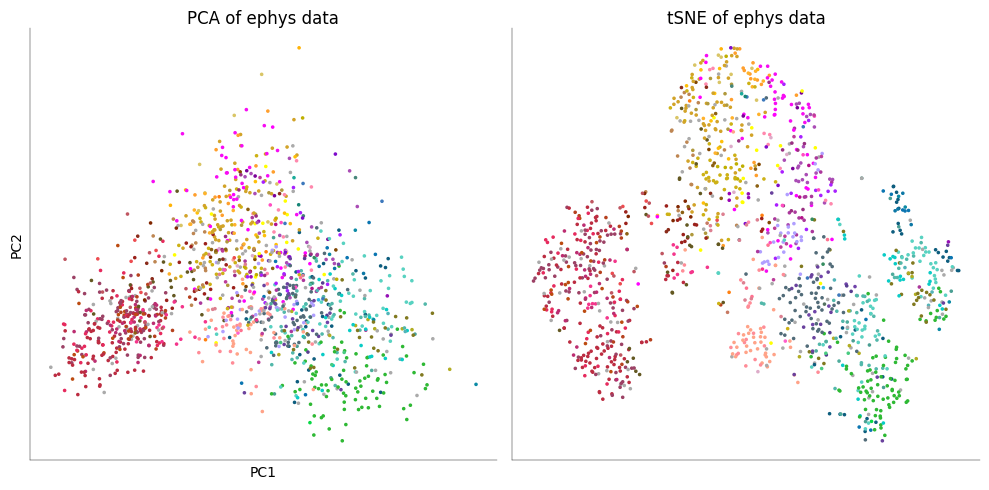

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(PCinit[:, 0], PCinit[:, 1], s=10, c=cluster_colors[keepcells], alpha=1)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].axis = "equal"
ax[0].set_title("PCA of ephys data")
ax[1].scatter(Z[:, 0], Z[:, 1], s=10, c=cluster_colors[keepcells], alpha=1)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].axis = "equal"
ax[1].set_title("tSNE of ephys data")
plt.tight_layout()

In [105]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probabilities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """
    n_clusters = len(m)  # number of clusters
    n_dims = x.shape[1]  # number of dimensions
    n_samples = x.shape[0]  # number of samples

    # Calculate the log likelihood of the data given the model
    expectation = np.zeros((n_samples, n_clusters), dtype=np.float64)

    for k in range(n_clusters):
        pi_k = p[k]
        mu_k = m[k]
        cov_k = S[k] + 1e-6 * np.eye(
            n_dims
        )  # Adding a small value for numerical stability
        expectation[:, k] = pi_k * stats.multivariate_normal(mean=mu_k, cov=cov_k).pdf(
            x
        )

    totals = np.sum(expectation, axis=1)

    # Ensure totals are not zero to avoid log(0)
    if np.any(totals == 0):
        raise ValueError("Some data points have zero probability under the model.")

    LL = np.sum(np.log(totals))

    # Number of parameters
    P = (n_clusters - 1) + n_clusters * n_dims + n_clusters * n_dims * (n_dims + 1) / 2

    bic = -2 * LL + P * np.log(n_samples)

    return bic, LL

In [106]:
possible_clusters = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(possible_clusters)))
LL = np.zeros((num_seeds, len(possible_clusters)))
sklearn_BIC = np.zeros((num_seeds, len(possible_clusters)))
sklearn_LL = np.zeros((num_seeds, len(possible_clusters)))

for i, n_clusters in enumerate(possible_clusters):
    for j in range(num_seeds):
        gmm = GMM(n_components=n_clusters, random_state=j).fit(ephysData_filtered)
        cluster_ids = gmm.predict(ephysData_filtered)
        likelihood = gmm.score_samples(ephysData_filtered)  # log likelihood
        means = gmm.means_
        covariances = gmm.covariances_
        weights = gmm.weights_
        BIC[j, i], LL[j, i] = mog_bic(ephysData_filtered, means, covariances, weights)
        sklearn_BIC[j, i] = gmm.bic(ephysData_filtered)
        sklearn_LL[j, i] = gmm.score(ephysData_filtered)

In [107]:
# Get the optimal number of clusters for the sklearn GMM
sklearn_model_index, sklearn_cluster_index = np.where(sklearn_BIC == sklearn_BIC.min())
sklearn_optimal_cluster_number = possible_clusters[sklearn_cluster_index[0]]
sklearn_lowest_bic = sklearn_BIC[sklearn_model_index[0], :]
print(f"Optimal number of clusters: {sklearn_optimal_cluster_number}")

Optimal number of clusters: 4


<ErrorbarContainer object of 3 artists>

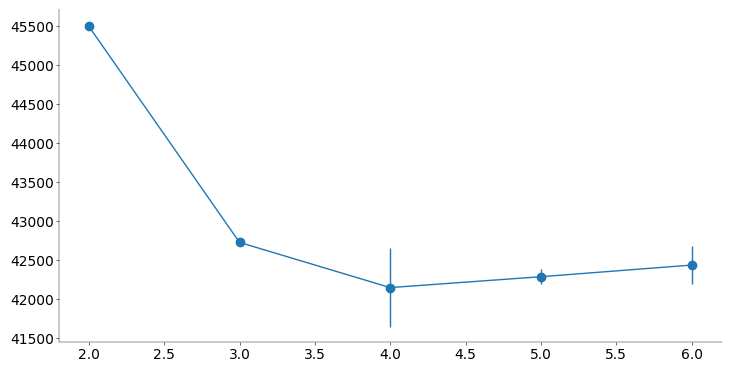

In [108]:
plt.errorbar(
    possible_clusters,
    BIC.mean(axis=0),
    yerr=BIC.std(axis=0),
    label="Custom BIC",
    fmt="o-",
)

In [109]:
def plot_ellipse(mean, cov, color, ax):

    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    ell = matplotlib.patches.Ellipse(
        mean,
        4 * v[0] ** 0.5,
        4 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
        label="Covariance",
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.4)
    ax.add_artist(ell)

    return ell

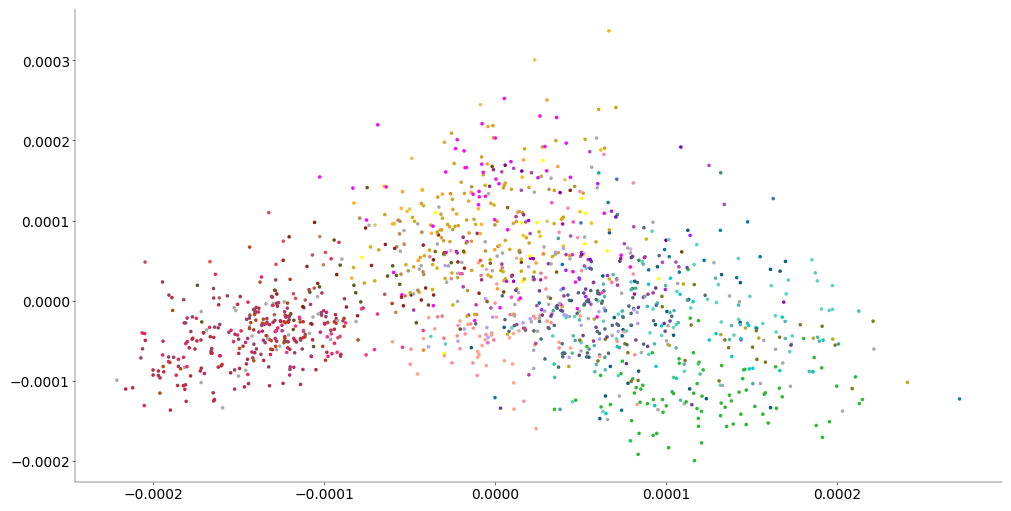

In [113]:
colors = ["red", "blue", "green", "purple", "orange", "black"]
gmm = GMM(n_components=sklearn_optimal_cluster_number, random_state=42).fit(
    ephysData_filtered
)


cluster_ids = gmm.predict(ephysData_filtered)
likelihood = gmm.score_samples(ephysData_filtered)  # log likelihood
means = gmm.means_
covariances = gmm.covariances_


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(PCinit[:, 0], PCinit[:, 1], s=10, c=cluster_colors[keepcells], alpha=1)
# plot means of clusters

Text(0, 0.5, '')

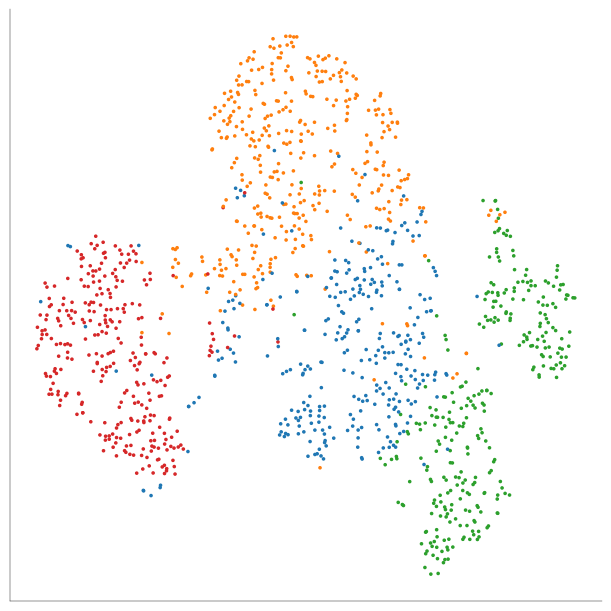

In [111]:
Z = TSNE(
    init=PCinit, early_exaggeration=4, random_state=42, perplexity=20
).fit_transform(ephysData_filtered)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(Z[:, 0], Z[:, 1], c=plt.cm.tab10(cluster_ids), s=10, alpha=1)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_4892/4267163475.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


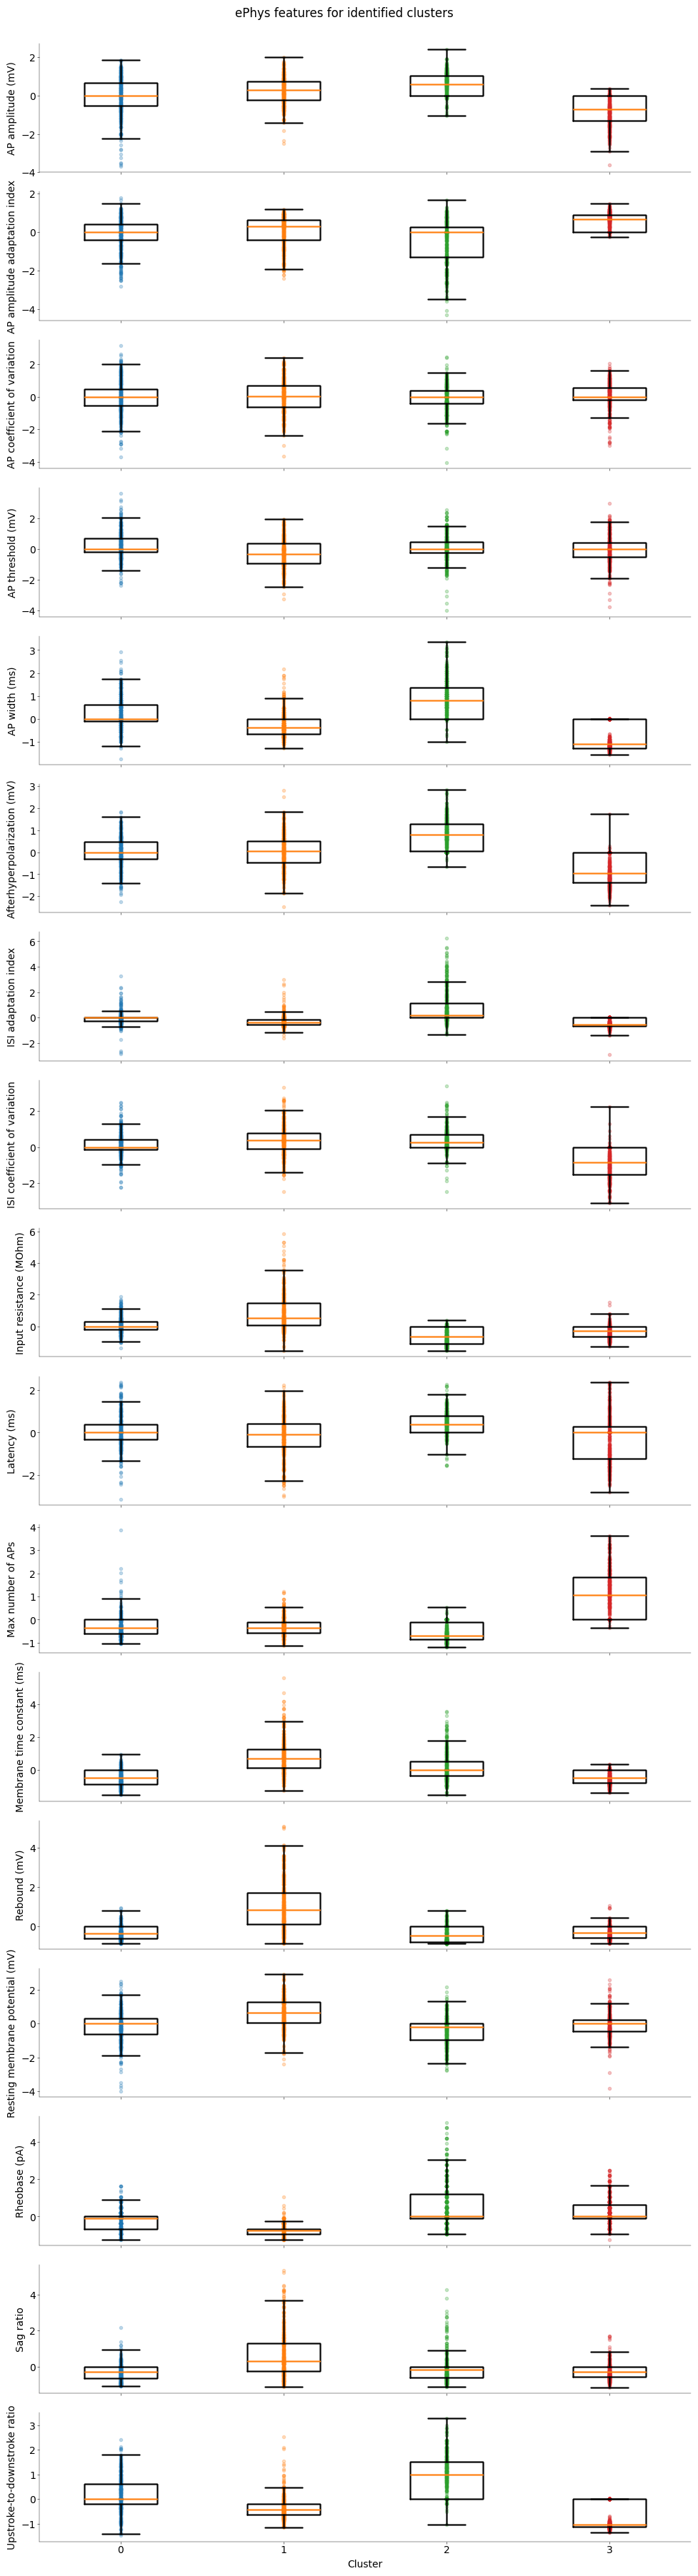

In [112]:
data = ephysData_filtered
features = ephysNames[~np.isin(ephysNames, features_exclude)]
mean_Per_group = np.zeros((len(features), len(np.unique(cluster_ids))))
std_Per_group = np.zeros((len(features), len(np.unique(cluster_ids))))
for i, c in enumerate(np.unique(cluster_ids)):
    mean_Per_group[:, i] = np.mean(data[cluster_ids == c, :], axis=0)
    std_Per_group[:, i] = np.std(data[cluster_ids == c, :], axis=0)


n_features = features.size
clusters_data = np.zeros((len(features), len(np.unique(cluster_ids)), data.shape[0]))

unique_clusters = np.unique(cluster_ids)
# Determine the max number of samples in any cluster
max_samples = max(np.sum(cluster_ids == c) for c in unique_clusters)

clusters_data = np.zeros((len(features), len(unique_clusters), max_samples))

for i, c in enumerate(unique_clusters):
    cluster_data = data[cluster_ids == c, :].T
    clusters_data[:, i, : cluster_data.shape[1]] = cluster_data

fig, ax = plt.subplots(len(features), 1, figsize=(10, 36), sharex=True)
for i, feature in enumerate(features):
    for j, c in enumerate(np.unique(cluster_ids)):
        ax[i].scatter(
            np.zeros(clusters_data.shape[2]) + j,
            clusters_data[i, j, :],
            # use the same colors as for gmm clusters
            color=plt.cm.tab10.colors[j],
            alpha=0.25,
        )
        ax[i].boxplot(
            clusters_data[i, :, :].T,
            positions=np.arange(len(np.unique(cluster_ids))),
            showfliers=False,
            patch_artist=False,
        )

    ax[i].set_xticks(np.arange(len(np.unique(cluster_ids))))
    ax[i].set_xticklabels(np.unique(cluster_ids))
    ax[i].set_ylabel(feature)
    ax[i].set_xlabel("Cluster") if i == len(features) - 1 else None
plt.suptitle("ePhys features for identified clusters", y=1.001)
plt.tight_layout()

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    